In [18]:
# load the training data and plot some orders
import pandas as pd
original = pd.read_csv('./data/cannon_training_data/training_flux_original.csv')
dwt = pd.read_csv('./data/cannon_training_data/training_flux_dwt.csv')


original

,order_number,K00001,K00002,K00003,K00006,K00007,K00008,K00010,K00017,K00018,...,K05057,K05107,K05119,K05236,K05379,K05393,K05782,K05900,K05949,K06102
0,1,0.887888,0.961784,0.910509,0.980752,0.967724,0.962385,0.971468,0.932977,0.947678,...,0.832746,0.879966,0.856301,0.913153,0.939817,0.797303,0.848383,0.924665,0.959712,0.924415
1,1,0.900360,0.920887,0.882835,0.974098,0.950504,0.955122,0.951018,0.926813,0.960360,...,0.811837,0.807939,0.865738,0.923977,0.827340,0.746135,0.839091,0.950875,0.949312,0.905572
2,1,0.899204,0.892733,0.843503,0.970504,0.936034,0.948174,0.947660,0.894121,0.944939,...,0.820637,0.773399,0.824578,0.900636,0.794363,0.729979,0.856352,0.953651,0.933316,0.890888
3,1,0.878677,0.884542,0.834057,0.968784,0.914628,0.957328,0.951140,0.867070,0.937888,...,0.817595,0.776110,0.804445,0.855672,0.775497,0.659858,0.865144,0.920648,0.920299,0.887540
4,1,0.880316,0.888214,0.809635,0.955754,0.902699,0.955839,0.948968,0.867972,0.941072,...,0.812537,0.776703,0.813627,0.894786,0.764683,0.600797,0.827955,0.954201,0.913257,0.890795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57915,16,0.959579,0.978119,0.964526,0.967625,0.957890,0.966036,0.979974,0.971481,0.956405,...,0.930180,0.970781,0.959528,0.959518,0.910897,0.938652,0.956470,0.908081,0.948652,0.951546
57916,16,0.972695,0.970518,0.963867,0.972855,0.960975,0.964732,0.988486,0.972528,0.970485,...,0.950601,0.968756,0.925420,0.939567,0.919685,0.929527,0.948438,0.924278,0.942550,0.961825
57917,16,0.981563,0.936416,0.951976,0.975237,0.962519,0.962950,0.985555,0.972042,0.962542,...,0.958589,0.943279,0.925529,0.935106,0.917105,0.919555,0.944721,0.943566,0.952478,0.975773
57918,16,0.964682,0.929439,0.944968,0.978705,0.968797,0.960595,0.982754,0.962530,0.980526,...,0.965521,0.938246,0.919396,0.925641,0.930995,0.975168,0.950449,0.951366,0.960796,0.959638


In [19]:
dwt

,order_number,K00001,K00002,K00003,K00006,K00007,K00008,K00010,K00017,K00018,...,K05057,K05107,K05119,K05236,K05379,K05393,K05782,K05900,K05949,K06102
0,1,1.089927,1.142968,1.252555,1.110441,1.154457,1.111269,1.102859,1.179585,1.091670,...,1.101061,1.141914,1.127210,1.083887,1.208487,1.100833,1.126284,1.067519,1.132623,1.094546
1,1,1.102854,1.102420,1.224760,1.104051,1.137592,1.104101,1.082551,1.173917,1.104596,...,1.080583,1.070161,1.136978,1.094847,1.096395,1.050018,1.117672,1.093919,1.122364,1.076006
2,1,1.102144,1.074609,1.185304,1.100718,1.123471,1.097245,1.079332,1.141711,1.089413,...,1.089806,1.035889,1.096141,1.071638,1.063794,1.034207,1.135599,1.096881,1.106505,1.061617
3,1,1.082050,1.066750,1.175730,1.099250,1.102404,1.106487,1.082944,1.115132,1.082593,...,1.087174,1.038859,1.076321,1.026799,1.045293,0.964419,1.145039,1.064059,1.093619,1.058554
4,1,1.084109,1.070745,1.151175,1.086465,1.090802,1.105080,1.080900,1.116491,1.086001,...,1.082514,1.039702,1.085803,1.066033,1.034833,0.905679,1.108483,1.097786,1.086703,1.062085
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57915,16,1.033006,1.051659,1.046022,1.002806,1.016984,1.016363,1.019654,1.037183,1.009521,...,1.017222,1.050484,1.056064,1.034049,0.997046,1.031778,1.037723,0.978919,1.016741,1.020951
57916,16,1.046067,1.044154,1.045764,1.008239,1.020204,1.015176,1.028374,1.038412,1.023636,...,1.037517,1.048661,1.021848,1.014159,1.006015,1.022530,1.029724,0.995040,1.010583,1.031174
57917,16,1.054879,1.010152,1.034286,1.010830,1.021887,1.013514,1.025657,1.038111,1.015729,...,1.045377,1.023392,1.021846,1.009761,1.003621,1.012432,1.026041,1.014252,1.020454,1.045065
57918,16,1.037942,1.003277,1.027703,1.014512,1.028308,1.011283,1.023074,1.028791,1.033749,...,1.052178,1.018572,1.015602,1.000359,1.017702,1.067918,1.031807,1.021974,1.028715,1.028870


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


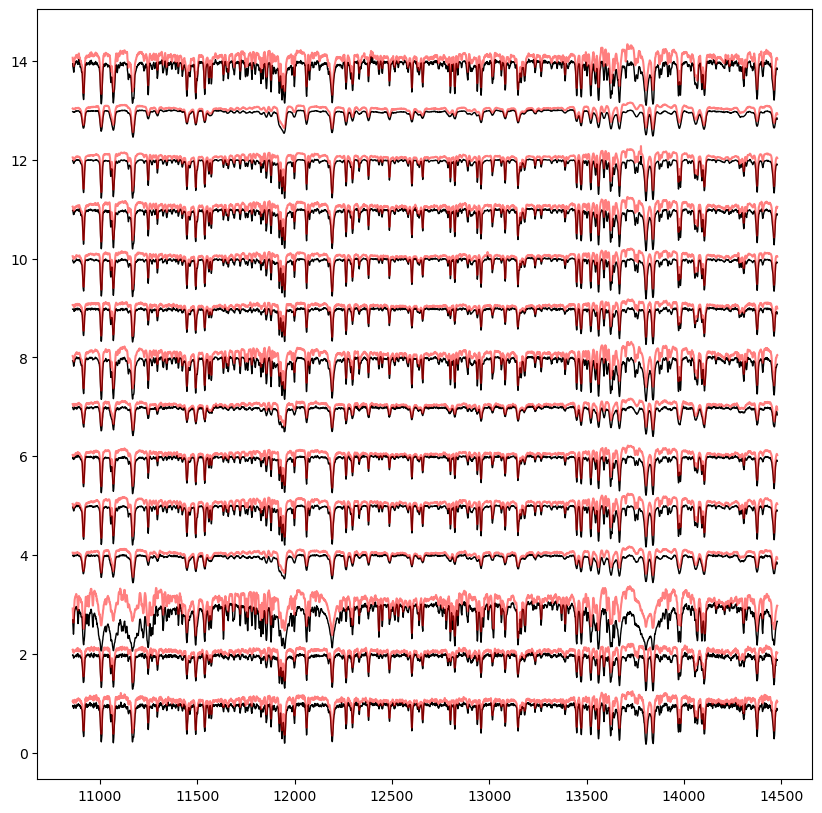

In [20]:
# this seems to be working! 
# the arrays are the same size and shape
# and the fluxes look different.
%pylab inline
order1_original = original.query('order_number==4')
order1_dwt = dwt.query('order_number==4')

figure(figsize=(10,10))

i=0
for column in order1_original.columns[1:15]:
    plot(order1_original[column]+i, 'k-', lw=1)
    plot(order1_dwt[column]+i, 'r-', lw=1.5, alpha=0.5)
    i+=1

In [21]:
# next I need to load the training data for a given order from the old fits files
# and make sure it matches how I would load the new one

In [23]:
from astropy.io import fits
normalized_flux_filename = './data/cannon_training_data/old/training_flux_order4.fits'
normalized_sigma_filename = './data/cannon_training_data/old/training_sigma_order4.fits'

normalized_flux_n = fits.open(normalized_flux_filename)[0].data
normalized_sigma_n = fits.open(normalized_sigma_filename)[0].data

normalized_flux_n.shape

(889, 3620)

In [35]:
test_flux = dwt.query('order_number==4').to_numpy()[:,1:].T
test_flux

array([[1.03791233, 1.05829034, 1.04745792, ..., 1.0544007 , 1.0203989 ,
        1.02594799],
       [1.08108108, 1.08641132, 1.06645576, ..., 1.01517593, 1.0062907 ,
        1.01960218],
       [0.91502414, 0.82171569, 0.75858313, ..., 0.9564381 , 0.97600084,
        0.97242413],
       ...,
       [1.05888453, 1.03219127, 1.00391666, ..., 0.9275189 , 0.93549901,
        0.94541302],
       [1.0184463 , 1.06737948, 1.04765868, ..., 1.03214857, 1.05703297,
        1.05827517],
       [1.02429612, 1.05723293, 1.07650244, ..., 0.91557094, 0.90043955,
        0.89180715]])

In [ ]:
# I think I'm ready to re-write this.

# so I have order numbers and I need to qurey basically all of the 
# rows where order_numebr is in that list.
# this is a good question for chatgpt